In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Activation,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline
scaler = MinMaxScaler()

In [2]:
f = open('all_total.json')
# returns JSON object as a dictionary
data = json.load(f)

total_cases_list = []
new_cases_list = []
    
pre_total_cases = 0
for row in data["rows"]:
    if "total_confirmed_cases" in row["key"]:
        temp_list = []
        temp_list.append(row["key"][0][0:10]) # Appending the date (the time part is trimmed)
        temp_list.append(row["value"]) # Appending the value on that date
        total_cases_list.append(temp_list)
        
        temp_list_2 = []
        temp_list_2.append(row["key"][0][0:10])
        temp_list_2.append((row["value"] - pre_total_cases)) # Appending the value on that date
        new_cases_list.append(temp_list_2)
        
        pre_total_cases = row["value"]
    
df_total = pd.DataFrame(total_cases_list, columns = ["Date", "Total Cases"])
df_new = pd.DataFrame(new_cases_list, columns = ["Date", "New Cases"])

In [3]:
df_total = df_total.set_index("Date")
df_new = df_new.set_index("Date")

In [4]:
#deleting two faulty values

df_total.drop('2021-09-16', inplace=True, axis=0)
df_total.drop('2021-09-17', inplace=True, axis=0)
df_total.drop('2021-07-21', inplace=True, axis=0)
df_total.drop('2021-07-22', inplace=True, axis=0)

df_new.drop('2021-09-16', inplace=True, axis=0)
df_new.drop('2021-09-17', inplace=True, axis=0)
df_new.drop('2021-07-21', inplace=True, axis=0)
df_new.drop('2021-07-22', inplace=True, axis=0)

In [5]:
df_new

,New Cases
Date,
2020-01-30,1
2020-02-02,1
2020-02-03,1
2020-03-02,2
2020-03-03,1
...,...
2022-01-06,90928
2022-01-07,117100
2022-01-08,141986


<AxesSubplot:xlabel='Date'>

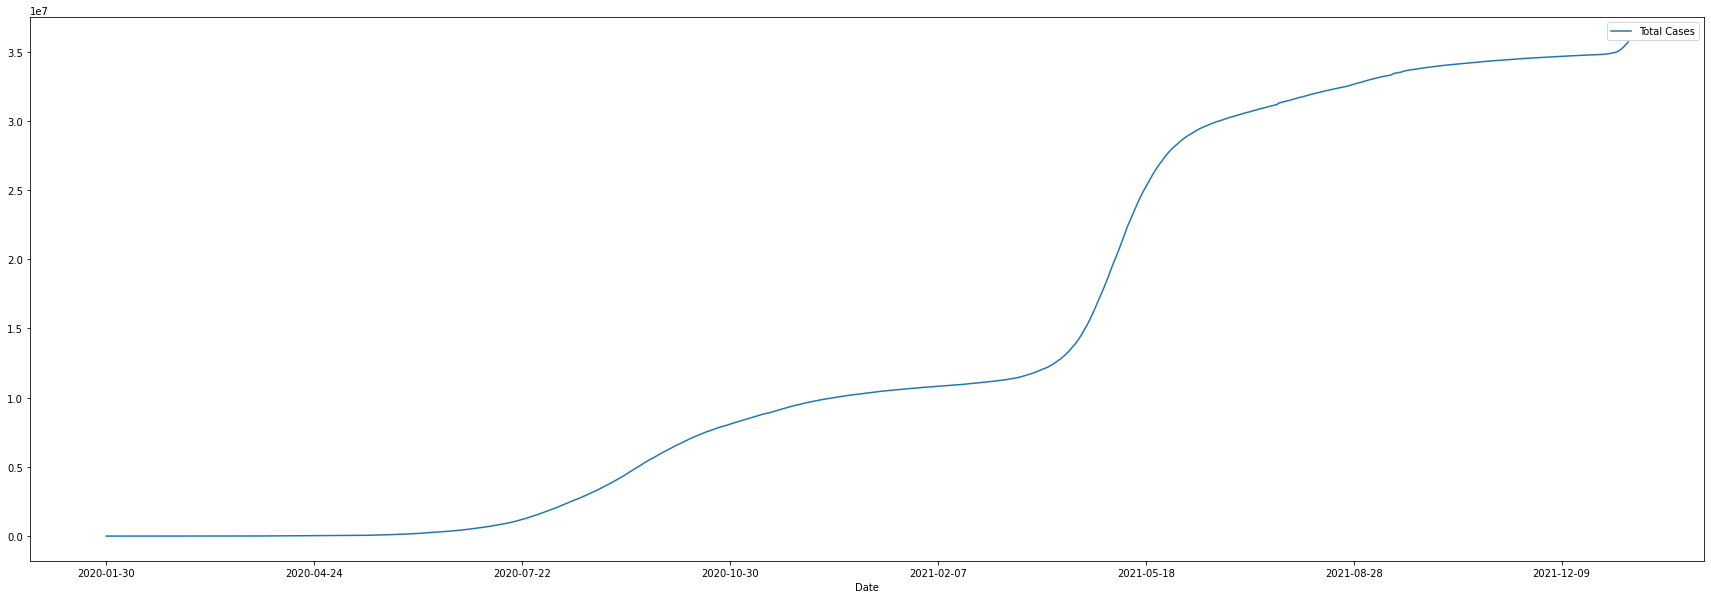

In [6]:
df_total.plot(figsize=(30, 10))

<AxesSubplot:xlabel='Date'>

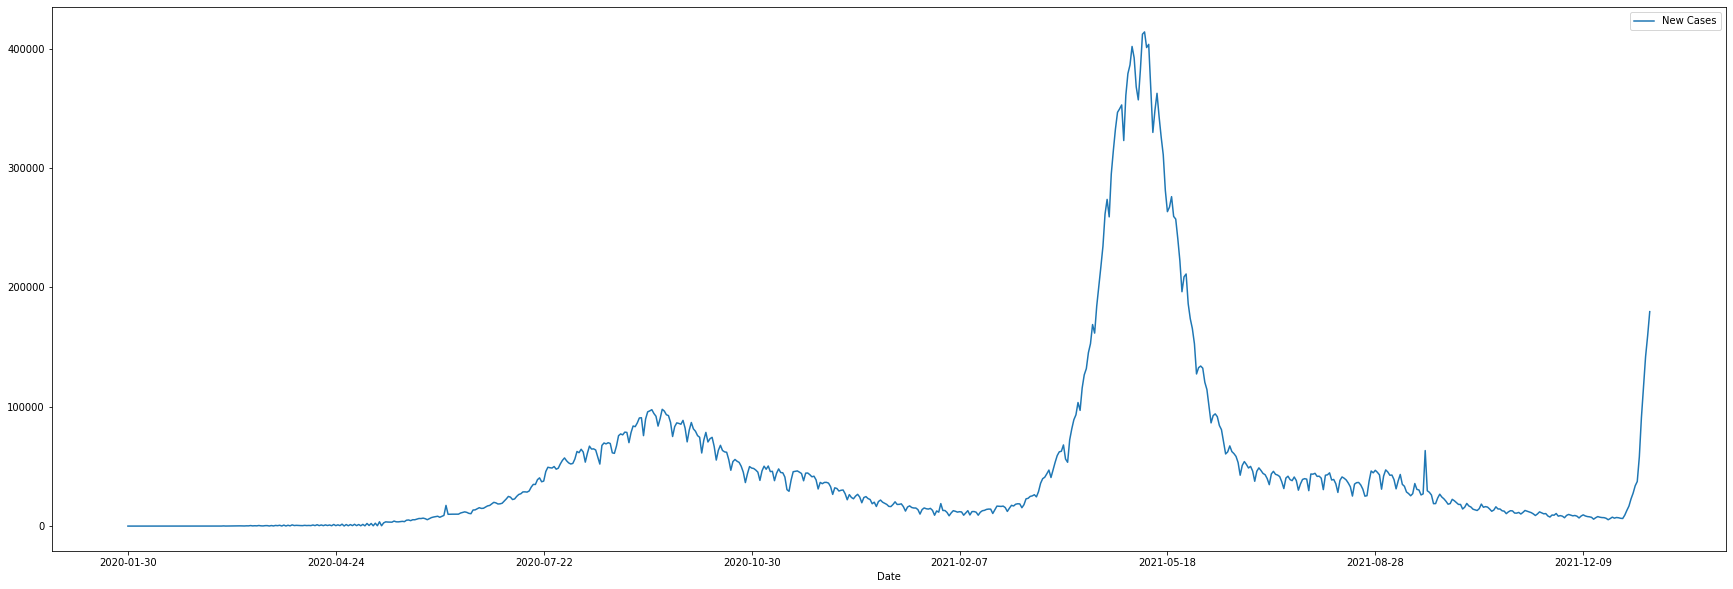

In [7]:
df_new.plot(figsize=(30, 10))

In [8]:
# Machine Learning Part

In [9]:
day = 90 # Number of days (Window size of time-series data)

In [10]:
k = 0

array = []
array_temp = []
train_data = []
train_labels = []

for i in range(len(df_new)):
    array_temp.append(df_new.iloc[i]['New Cases'])

array_temp = np.array(array_temp).reshape(-1,1)
array_temp = scaler.fit_transform(array_temp)
array_temp = array_temp.tolist()

for i in array_temp:
    array.append(i[0])

for i in range(len(array)):
    try:
        #train_data.append(array[day*k:day*(k+1)]) # dividing the dataset into 'day' days of data
        #train_labels.append([array[day*(k+1)]])
        train_data.append(array[k:day+k]) # Creating inner lists with 'day' days of data
        train_labels.append([array[day+k]])
        k+=1
    except:
        break

#train_data = np.squeeze(train_data)
#train_labels = np.array(train_labels)
#train_data.shape


# The last rows will contain None value because the total size of array is not divisible by 'day'.
# So, some of the values in the last row will be None as they have no values.
length = max(map(len, train_data))
train_data=np.array([xi+[None]*(length-len(xi)) for xi in train_data]).astype('float32')

length = max(map(len, train_labels))
train_labels = np.array([xi+[None]*(length-len(xi)) for xi in train_labels]).astype('float32')

#train_labels=np.array(train_labels)

In [11]:
print(train_data.shape)
print(train_labels.shape)

(644, 90)
(643, 1)


In [12]:
# Deleting the last rows because it contains None value
#train_data = np.delete(train_data, (104), axis=0)
#train_labels = np.delete(train_labels, (103), axis=0)

In [13]:
train_data = train_data[:len(train_labels)]
train_data = np.expand_dims(train_data,1)
train_data.shape

(643, 1, 90)

In [14]:
train_data[1]

array([[2.41436260e-06, 2.41436260e-06, 4.82872520e-06, 2.41436260e-06,
        9.89888649e-05, 3.13867131e-05, 3.13867131e-05, 2.41436260e-06,
        2.41436260e-06, 9.65745039e-06, 9.65745039e-06, 2.41436260e-06,
        2.17292636e-05, 3.38010759e-05, 0.00000000e+00, 7.24308757e-06,
        9.65745039e-06, 2.65579874e-05, 0.00000000e+00, 2.41436260e-06,
        2.65579874e-05, 2.41436264e-05, 9.65745039e-06, 3.62154387e-05,
        2.41436260e-06, 1.44861751e-05, 5.31159749e-05, 6.76021518e-05,
        8.45026880e-05, 6.03590634e-05, 9.89888649e-05, 0.00000000e+00,
        8.69170544e-05, 7.24308775e-05, 0.00000000e+00, 1.03817591e-04,
        2.41436260e-06, 1.40033022e-04, 6.51877926e-05, 0.00000000e+00,
        1.03817591e-04, 1.06231950e-04, 1.03817591e-04, 1.08646316e-04,
        7.24308775e-05, 3.59740021e-04, 8.69170544e-05, 1.69005376e-04,
        1.08646316e-04, 1.13475042e-04, 3.23524582e-04, 3.71811824e-04,
        6.71192771e-04, 4.75629437e-04, 3.16281483e-04, 2.510937

In [15]:
train_labels[1]

array([0.0027741], dtype=float32)

In [16]:
model = Sequential()

model.add(LSTM(250,input_shape=(1,day)))
model.add(Dropout(0.5))


model.add(Dense(250,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(day,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='relu'))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 250)               341000    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                22590     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

In [17]:
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

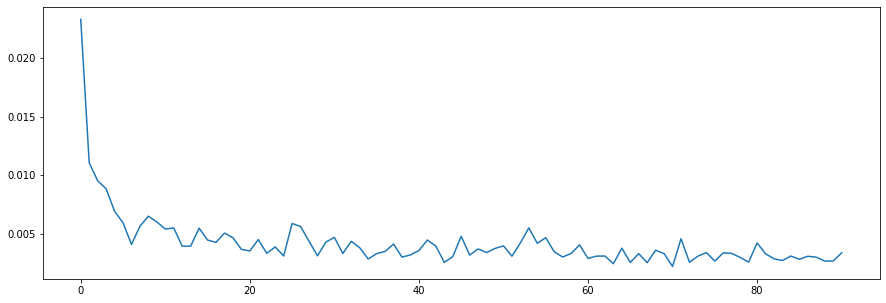

In [18]:
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.plot(epochs,loss)

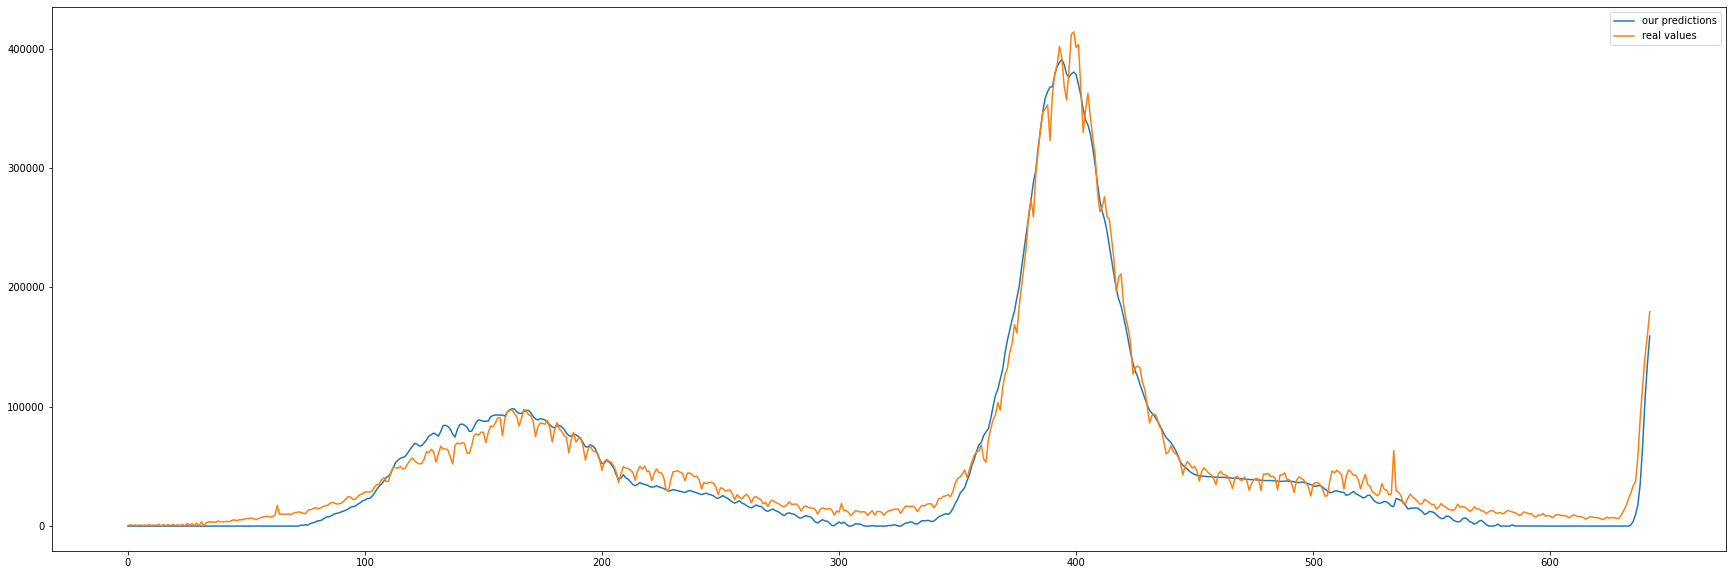

In [19]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plt.legend()

In [20]:
# Predicting Future Events

In [21]:
days_to_predict = 90
seed = array[-day:]
#seed

In [22]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)

#seed

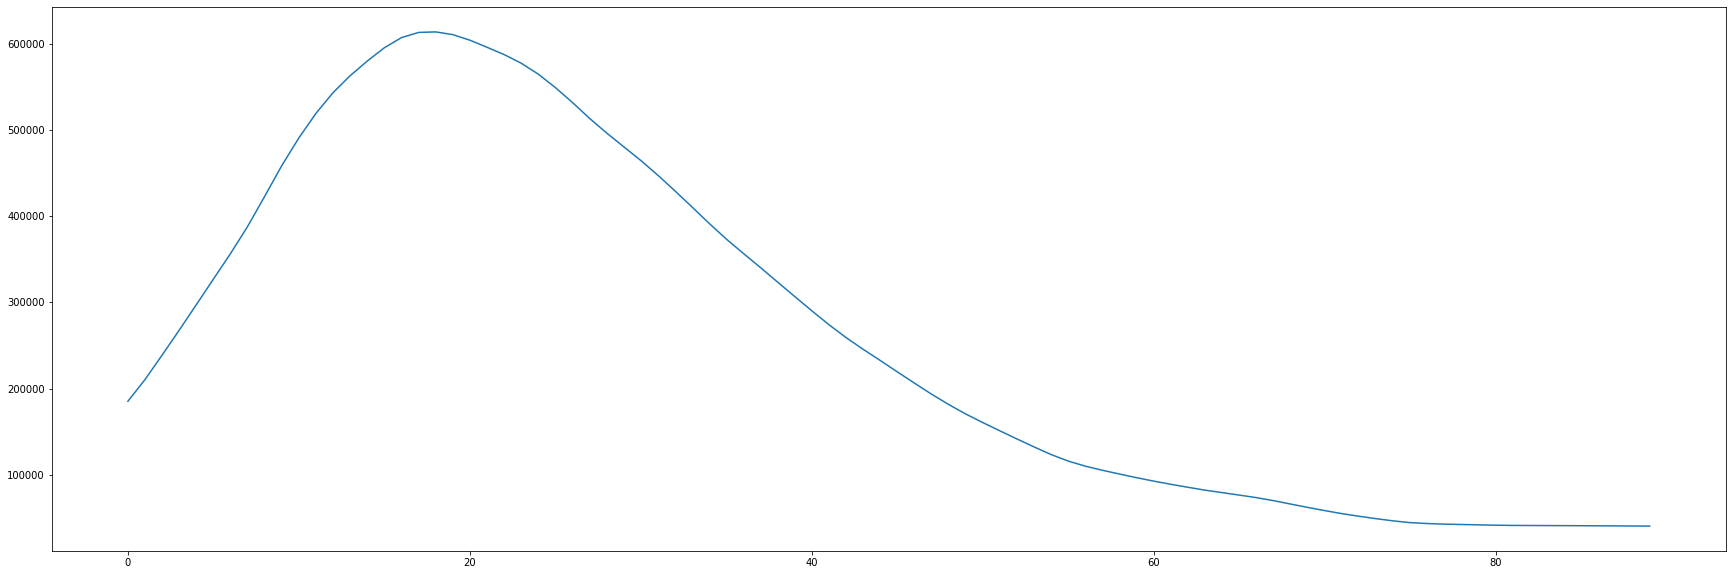

In [23]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.plot(range(0,days_to_predict),upcoming_days_prediction)

In [24]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))

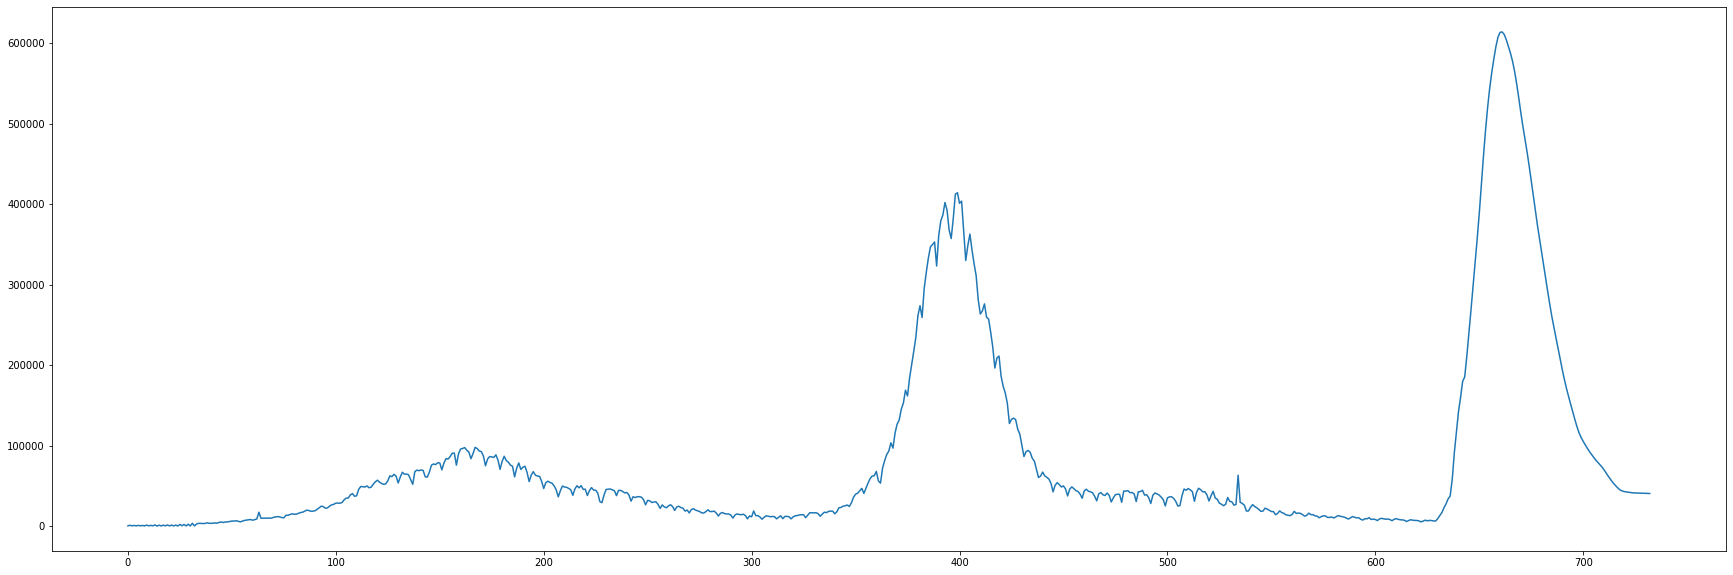

In [25]:
plt.figure(figsize=(30,10))
plt.plot(arr_with_pred)

In [26]:
total_new_cases = 0
for i in upcoming_days_prediction:
    total_new_cases += i[0]
    #print(i)
print(total_new_cases)

23417088.67804143
